# MNIST classification

This tutorial builds a quantum neural network (QNN) to classify a simplified version of MNIST, similar to the approach used in <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al</a>. The performance of the quantum neural network on this classical data problem is compared with a classical neural network.

In [5]:
import numpy as np
import pandas as pd

from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.regularizers import l2

from spektral.datasets import mnist
from spektral.utils.sparse import sp_matrix_to_sp_tensor
from spektral.utils import normalized_laplacian
from spektral.data import MixedLoader, BatchLoader
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import sparse_categorical_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from spektral.data import MixedLoader
from spektral.datasets.mnist import MNIST
from spektral.layers import GATConv, GCNConv, GeneralConv, GlobalSumPool
from spektral.utils.sparse import sp_matrix_to_sp_tensor

# Parameters


## Setup

Now import TensorFlow and the module dependencies:

In [6]:
import tensorflow as tf
import cProfile

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## 1. Load the data

In this tutorial you will build a binary classifier to distinguish between the digits 3 and 6, following <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> This section covers the data handling that:

- Loads the raw data from Keras.
- Filters the dataset to only 3s and 6s.
- Downscales the images so they fit can fit in a quantum computer.
- Removes any contradictory examples.
- Converts the binary images to Cirq circuits.
- Converts the Cirq circuits to TensorFlow Quantum circuits. 

### 1.1 Load the raw data

Load the MNIST dataset distributed with Keras. 

In [7]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


Filter the dataset to keep just the 3s and 6s,  remove the other classes. At the same time convert the label, `y`, to boolean: `True` for `3` and `False` for 6. 

In [8]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [9]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


Show the first example:

True


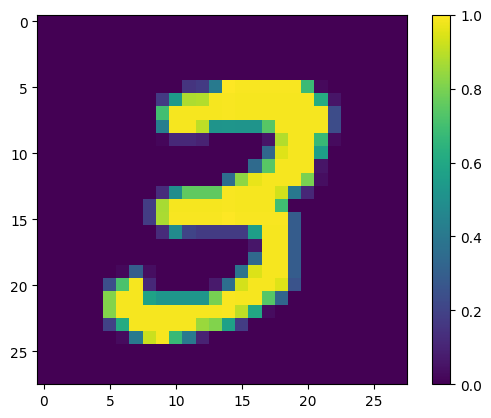

In [10]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

### 1.2 Downscale the images

An image size of 28x28 is much too large for current quantum computers. Resize the image down to 4x4:

In [121]:
rescale_l=4

x_train_small = tf.image.resize(x_train, (rescale_l,rescale_l)).numpy()
x_test_small = tf.image.resize(x_test, (rescale_l,rescale_l)).numpy()

Again, display the first training example—after resize: 

True


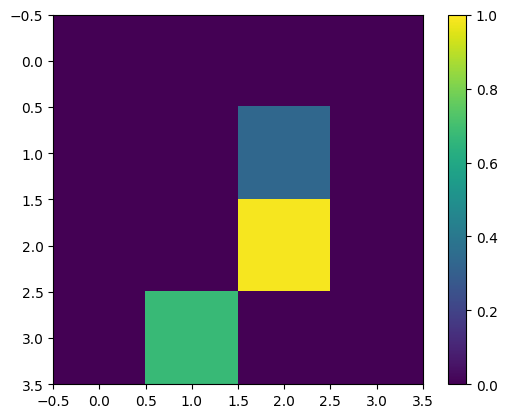

In [122]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

### 1.3 Remove contradictory examples

From section *3.3 Learning to Distinguish Digits* of <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a>, filter the dataset to remove images that are labeled as belonging to both classes.

This is not a standard machine-learning procedure, but is included in the interest of following the paper.

In [123]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
        orig_x[tuple(x.flatten())] = x
        mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for flatten_x in mapping:
        x = orig_x[flatten_x]
        labels = mapping[flatten_x]
        if len(labels) == 1:
            new_x.append(x)
            new_y.append(next(iter(labels)))
        else:
            # Throw out images that match more than one label.
            pass
    
    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_3)
    print("Number of unique 6s: ", num_uniq_6)
    print("Number of unique contradicting labels (both 3 and 6): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))
    
    return np.array(new_x), np.array(new_y)

The resulting counts do not closely match the reported values, but the exact procedure is not specified.

It is also worth noting here that applying filtering contradictory examples at this point does not totally prevent the model from receiving contradictory training examples: the next step binarizes the data which will cause more collisions. 

In [124]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 10387
Number of unique 3s:  4912
Number of unique 6s:  5426
Number of unique contradicting labels (both 3 and 6):  49

Initial number of images:  12049
Remaining non-contradicting unique images:  10338


### 1.4 Encode the data as quantum circuits

To process images using a quantum computer, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> proposed representing each pixel with a qubit, with the state depending on the value of the pixel. The first step is to convert to a binary encoding.

In [183]:
print(x_train_nocon.shape, y_train_nocon.shape)
print(x_test_small.shape, y_test.shape)
print(x_train_nocon[0])

(10338, 4, 4, 1) (10338,)
(1968, 4, 4, 1) (1968,)
[[[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.33333334]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.9882353 ]
  [0.        ]]

 [[0.        ]
  [0.6745098 ]
  [0.        ]
  [0.        ]]]


In [126]:
import numpy as np
import scipy.sparse as sp
from sklearn.neighbors import kneighbors_graph
from tensorflow.keras.datasets import mnist as m

from spektral.data import Dataset, Graph

mred_size = x_train_nocon[0][0].shape[0]

class mnistred(Dataset):
    """
    The MNIST images used as node features for a grid graph, as described by
    [Defferrard et al. (2016)](https://arxiv.org/abs/1606.09375).

    This dataset is a graph signal classification task, where graphs are
    represented in mixed mode: one adjacency matrix, many instances of node
    features.

    For efficiency, the adjacency matrix is stored in a special attribute of the
    dataset and the Graphs only contain the node features.
    You can access the adjacency matrix via the `a` attribute.

    The node features of each graph are the MNIST digits vectorized and rescaled
    to [0, 1].
    Two nodes are connected if they are neighbours on the grid.
    Labels represent the MNIST class associated to each sample.

    **Note:** the last 10000 samples are the default test set of the MNIST
    dataset.

    **Arguments**

    - `p_flip`: if >0, then edges are randomly flipped from 0 to 1 or vice versa
    with that probability.
    - `k`: number of neighbours of each node.
    """

    def __init__(self, p_flip=0.0, k=4, **kwargs):
        self.a = None
        self.k = k
        self.p_flip = p_flip
        super().__init__(**kwargs)

    def read(self):
        self.a = _mnist_grid_graph(self.k)
        self.a = _flip_random_edges(self.a, self.p_flip)

        (x_train, y_train), (x_test, y_test_red) = (x_train_nocon, y_train_nocon), (x_test_small, y_test)
        x = np.vstack((x_train, x_test))
        y = np.concatenate((y_train, y_test_red), 0)
        x = x.reshape(-1, mred_size**2, 1)

        return [Graph(x=x_, y=y_) for x_, y_ in zip(x, y)]


def _grid_coordinates(side):
    M = side**2
    x = np.linspace(0, 1, side, dtype=np.float32)
    y = np.linspace(0, 1, side, dtype=np.float32)
    xx, yy = np.meshgrid(x, y)
    z = np.empty((M, 2), np.float32)
    z[:, 0] = xx.reshape(M)
    z[:, 1] = yy.reshape(M)
    return z


def _get_adj_from_data(X, k, **kwargs):
    A = kneighbors_graph(X, k, **kwargs).toarray()
    A = sp.csr_matrix(np.maximum(A, A.T))

    return A


def _mnist_grid_graph(k):
    X = _grid_coordinates(mred_size)
    A = _get_adj_from_data(
        X, k, mode="connectivity", metric="euclidean", include_self=False
    )

    return A
def _flip_random_edges(A, p_swap):
    if not A.shape[0] == A.shape[1]:
        raise ValueError("A must be a square matrix.")
    dtype = A.dtype
    A = sp.lil_matrix(A).astype(bool)
    n_elem = A.shape[0] ** 2
    n_elem_to_flip = round(p_swap * n_elem)
    unique_idx = np.random.choice(n_elem, replace=False, size=n_elem_to_flip)
    row_idx = unique_idx // A.shape[0]
    col_idx = unique_idx % A.shape[0]
    idxs = np.stack((row_idx, col_idx)).T
    for i in idxs:
        i = tuple(i)
        A[i] = np.logical_not(A[i])
    A = A.tocsr().astype(dtype)
    A.eliminate_zeros()
    return A

In [192]:
data_tr[0]

Graph(n_nodes=16, n_node_features=1, n_edge_features=None, n_labels=1)

## 2. Classical Graph neural network



The following block contains a method to extract an adjacency matrix from the pixel values in the reshape image

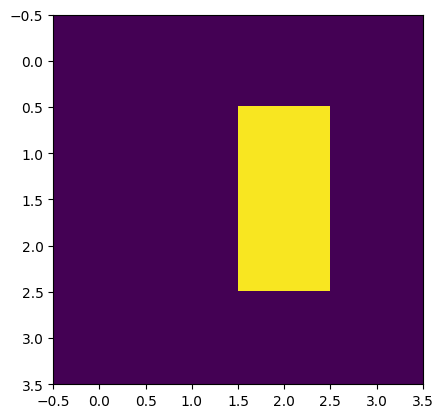

In [127]:
plt.imshow(x_train_small[67,:,:,0], vmin=0, vmax=1)


In [237]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy,  mse
from tensorflow.keras.metrics import sparse_categorical_accuracy, categorical_accuracy, binary_accuracy 
from spektral.layers import GATConv, GlobalAvgPool, GeneralConv, GCSConv
import keras.backend as K 
import scipy.sparse as sp
import spektral
from spektral.data import Dataset, DisjointLoader, Graph
from spektral.layers import GCSConv, GlobalAvgPool
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import categorical_accuracy
data=mnistred()

adj=data.a
print(type(adj))
lastrain=x_test_small.shape[0]
# Create filter for GCN and convert to sparse tensor.
data.a = GeneralConv.preprocess(data.a)
print(type(data.a))

data.a = sp_matrix_to_sp_tensor(data.a)

# Train/valid/test split
data_tr, data_te = data[:-lastrain], data[-lastrain:]
data_tr, data_va = data_tr[:-lastrain], data_tr[-lastrain:]
print(data_tr, data_te,data_va)
# Train/valid/test split
epochs = 1000  # Number of training epochs
l2_reg = 5e-4  # Regularization rate for l2
es_patience = 40  # Patience for early stopping
batch_size = 32  # Batch size

# Specify device to be used by TensorFlow
device = '/device:CPU:0'

# We use a MixedLoader since the dataset is in mixed mode
loader_tr = MixedLoader(data_tr, batch_size=batch_size, epochs=epochs)
loader_va = MixedLoader(data_va, batch_size=batch_size)
loader_te = MixedLoader(data_te, batch_size=batch_size)


# Build model
class Net(Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = GeneralConv(4, activation="relu", kernel_regularizer=l2(l2_reg), use_bias=True)
        self.flatten = Flatten()
        #self.fc1 = Dense(10, activation="relu")
        self.fc2 = Dense(2, activation="softmax")  # MNIST binary has 10 classes in binary notation :)

    def call(self, inputs):
        x, a = inputs
        with tf.device(device):
            #print(x[-1],"this is x shape -1")
            #print(a, "this is a, the adjacency matrix")
            x = self.conv1([x, a])
            #x = self.conv2([x, a])
            #print(x,"this is x")
            output = self.flatten(x)
            #print(output, "after flattening")
            #output = self.fc1(output)
            output = self.fc2(output)

        return output

# Create model
with tf.device(device):
    model = Net()
    optimizer = Adam(learning_rate=0)
    loss_fn = SparseCategoricalCrossentropy()
    fltr = normalized_laplacian(adj)

# Training function
@tf.function
def train_on_batch(inputs, target):
    with tf.device(device):
        with tf.GradientTape() as tape:
            predictions = model(inputs, training=True)
            loss = loss_fn(target, predictions) #+ sum(model.losses)
            acc = tf.reduce_mean(sparse_categorical_accuracy(target, predictions))

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss, acc


# Evaluation function
def evaluate(loader):
    step = 0
    results = []
    for batch in loader:
        step += 1
        inputs,target = batch
        
        with tf.device(device):
            predictions = model(inputs, training=False)
            loss = loss_fn(target, predictions)
            acc = tf.reduce_mean(sparse_categorical_accuracy(target, predictions))
            results.append((loss, acc, len(target)))  # Keep track of batch size
            print(optimizer.lr)
            if step == loader.steps_per_epoch:
                results = np.array(results)
                return np.average(results[:, :-1], 0, weights=results[:, -1])
            

# Setup training
best_val_loss = 10000
current_patience = es_patience

model = Net()
optimizer = Adam(learning_rate=0)
#loss_fn= tf.keras.losses.mse()



################################################################################
# Learning rate range test
################################################################################
lrrt_results = []
lrrt_lrs = []
lr_start = 1e-15
lr_end = 0.1

#model.set_weights(tf.keras.initializers.GlorotUniform(seed=42))

for lr in np.logspace(np.log10(lr_start), np.log10(lr_end), num=40):
    optimizer.lr = 0
    

    loss, acc = train_on_batch(*next(loader_tr))
    #print(loss)
    acc=np.array(acc)
    loss=np.mean(loss)
    #print(loss, acc)
    #print(*next(loader_tr)[0])
    #print("WHAT ARE YOU \n \n \n")
    print(("Loss: {:.3f} - Acc: {:.3f} - Lr: {:}".format(
                 loss, acc, optimizer.lr
            )
    ))
           
    lrrt_results.append(loss)
    lrrt_lrs.append(lr)

lrrt_results = np.array(lrrt_results)
best_lr = lrrt_lrs[np.argmin(lrrt_results)]/10

print("THE BEST LR IS", best_lr)
################################################################################
# Fit model
################################################################################


optimizer = Adam(learning_rate=best_lr)


<class 'scipy.sparse._csr.csr_matrix'>
<class 'scipy.sparse._csr.csr_matrix'>
mnistred(n_graphs=8370) mnistred(n_graphs=1968) mnistred(n_graphs=1968)


/home/stefanotroffa/miniconda3/envs/tf/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'mnistred' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Loss: 1.374 - Acc: 0.531 - Lr: <tf.Variable 'Adam/learning_rate:0' shape=() dtype=int32, numpy=0>
Loss: 1.430 - Acc: 0.562 - Lr: <tf.Variable 'Adam/learning_rate:0' shape=() dtype=int32, numpy=0>
Loss: 0.938 - Acc: 0.594 - Lr: <tf.Variable 'Adam/learning_rate:0' shape=() dtype=int32, numpy=0>
Loss: 1.284 - Acc: 0.594 - Lr: <tf.Variable 'Adam/learning_rate:0' shape=() dtype=int32, numpy=0>
Loss: 1.281 - Acc: 0.594 - Lr: <tf.Variable 'Adam/learning_rate:0' shape=() dtype=int32, numpy=0>
Loss: 1.890 - Acc: 0.375 - Lr: <tf.Variable 'Adam/learning_rate:0' shape=() dtype=int32, numpy=0>
Loss: 1.064 - Acc: 0.656 - Lr: <tf.Variable 'Adam/learning_rate:0' shape=() dtype=int32, numpy=0>
Loss: 0.678 - Acc: 0.750 - Lr: <tf.Variable 'Adam/learning_rate:0' shape=() dtype=int32, numpy=0>
Loss: 1.294 - Acc: 0.469 - Lr: <tf.Variable 'Adam/learning_rate:0' shape=() dtype=int32, numpy=0>
Loss: 1.321 - Acc: 0.594 - Lr: <tf.Variable 'Adam/learning_rate:0' shape=() dtype=int32, numpy=0>
Loss: 1.105 - Acc: 0

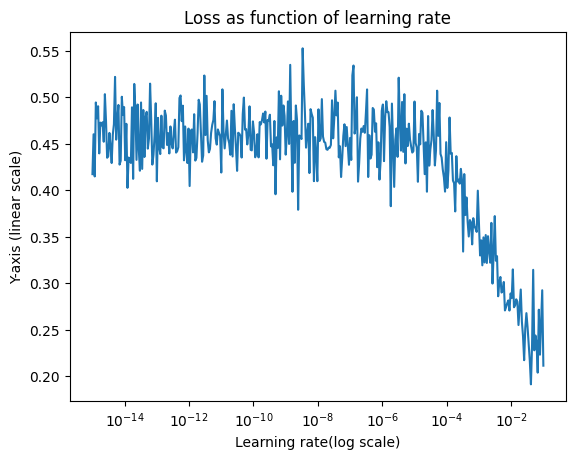

In [233]:
losses = lrrt_results
import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
x = np.array(lrrt_lrs)
y = losses

# Create the plot
fig, ax = plt.subplots()
ax.semilogx(x, y)
ax.set_xlabel('Learning rate(log scale)')
ax.set_ylabel('Y-axis (linear scale)')
ax.set_title('Loss as function of learning rate')
plt.show()

In [196]:
model.summary(print_fn=None,
    expand_nested=True,
    show_trainable=True,
    layer_range=None)

Model: "net_60"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 general_conv_91 (GeneralCon  multiple                 24        Y          
 v)                                                                         
                                                                            
 flatten_54 (Flatten)        multiple                  0         Y          
                                                                            
 dense_101 (Dense)           multiple                  130       Y          
                                                                            
Total params: 154
Trainable params: 146
Non-trainable params: 8
____________________________________________________________________________


In [238]:
optimizer = Adam(learning_rate=0)

# Setup training
best_val_loss = 10000
current_patience = patience
best_weights=None
# Training loop
results_tr = []
step=0
import time
start_time=time.time()
acc_te=[]
acc_va=[]
loss_te=[]
loss_va=[]
for batch in loader_tr:
    step += 1
    
    # Training step
    inputs, target = batch

    loss, acc = train_on_batch(inputs, target)
    results_tr.append((loss, acc, len(target)))
    
    if step == loader_tr.steps_per_epoch:
        #optimizer.lr = optimizer.lr/1.1
        results_va = evaluate(loader_va)
        results_te = evaluate(loader_te)

        if results_va[0] < best_val_loss:
            best_val_loss = results_va[0]
            current_patience = patience
            best_weights = model.get_weights()
        else:
            current_patience -= 1
            if current_patience == 0:
                print("Early stopping")
                break

        # Print results
        results_tr = np.array(results_tr)
        results_tr = np.average(results_tr[:, :-1], 0, weights=results_tr[:, -1])
        elapsed_time = time.time() - start_time

        print(
            "Train loss: {:.4f}, acc: {:.4f} | "
            "Valid loss: {:.4f}, acc: {:.4f} | "
            "Test loss: {:.4f}, acc: {:.4f} | "
            "Elapsed time: {:.2f}s| lr:{:}".format(
                *results_tr, *results_va, *results_te, elapsed_time,model.optimizer.lr.numpy()
            )
        )
        acc_te.append(results_te[1])
        acc_va.append(results_va[1])
        loss_te.append(results_te[0])
        loss_va.append(results_va[0])
        # Reset epoch
        results_tr = []
        step = 0
model.set_weights(best_weights)  # Load best model

################################################################################
# Evaluate model
################################################################################
#model.set_weights(best_weights)  # Load best model
test_loss, test_acc = evaluate(loader_te)
print("Done. Test loss: {:.4f}. Test acc: {:.3f}".format(test_loss, test_acc))

ValueError: in user code:

    File "/tmp/ipykernel_15114/3589379666.py", line 82, in train_on_batch  *
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    File "/home/stefanotroffa/miniconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 695, in apply_gradients  **
        self._create_all_weights(var_list)
    File "/home/stefanotroffa/miniconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 957, in _create_all_weights
        _ = self.iterations
    File "/home/stefanotroffa/miniconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 965, in __getattribute__
        return super().__getattribute__(name)
    File "/home/stefanotroffa/miniconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 1140, in iterations
        self._iterations = self.add_weight(
    File "/home/stefanotroffa/miniconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 1352, in add_weight
        variable = self._add_variable_with_custom_getter(
    File "/home/stefanotroffa/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/base_layer_utils.py", line 134, in make_variable
        return tf1.Variable(

    ValueError: tf.function only supports singleton tf.Variables created on the first call. Make sure the tf.Variable is only created once or created outside tf.function. See https://www.tensorflow.org/guide/function#creating_tfvariables for more information.


In [229]:
import tensorflow
help(tensorflow.keras.Model)

Help on class Model in module keras.engine.training:

class Model(keras.engine.base_layer.Layer, keras.utils.version_utils.ModelVersionSelector)
 |  Model(*args, **kwargs)
 |  
 |  `Model` groups layers into an object with training and inference features.
 |  
 |  Args:
 |      inputs: The input(s) of the model: a `keras.Input` object or list of
 |          `keras.Input` objects.
 |      outputs: The output(s) of the model. See Functional API example below.
 |      name: String, the name of the model.
 |  
 |  There are two ways to instantiate a `Model`:
 |  
 |  1 - With the "Functional API", where you start from `Input`,
 |  you chain layer calls to specify the model's forward pass,
 |  and finally you create your model from inputs and outputs:
 |  
 |  ```python
 |  import tensorflow as tf
 |  
 |  inputs = tf.keras.Input(shape=(3,))
 |  x = tf.keras.layers.Dense(4, activation=tf.nn.relu)(inputs)
 |  outputs = tf.keras.layers.Dense(5, activation=tf.nn.softmax)(x)
 |  model = tf.kera

### 2.2 Wrap the model-circuit in a tfq-keras model

Build the Keras model with the quantum components. This model is fed the "quantum data", from `x_train_circ`, that encodes the classical data. It uses a *Parametrized Quantum Circuit* layer, `tfq.layers.PQC`, to train the model circuit, on the quantum data.

To classify these images, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> proposed taking the expectation of a readout qubit in a parameterized circuit. The expectation returns a value between 1 and -1.

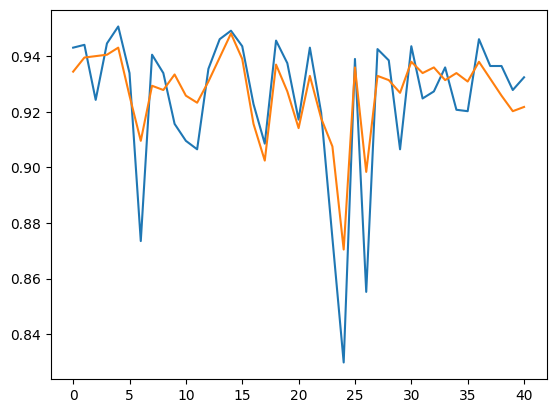

In [208]:
plt.plot(acc_te)
plt.plot(acc_va)

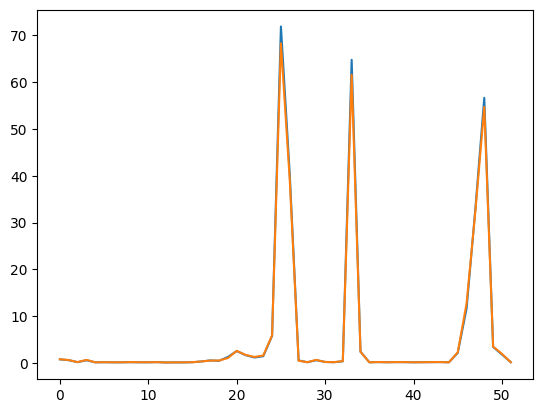

In [210]:
plt.plot(loss_va)
plt.plot(loss_te)

In [ ]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

Next, describe the training procedure to the model, using the `compile` method.

Since the the expected readout is in the range `[-1,1]`, optimizing the hinge loss is a somewhat natural fit. 

Note: Another valid approach would be to shift the output range to `[0,1]`, and treat it as the probability the model assigns to class `3`. This could be used with a standard a `tf.losses.BinaryCrossentropy` loss.

To use the hinge loss here you need to make two small adjustments. First convert the labels, `y_train_nocon`, from boolean to `[-1,1]`, as expected by the hinge loss.

In [ ]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

Second, use a custiom `hinge_accuracy` metric that correctly handles `[-1, 1]` as the `y_true` labels argument. 
`tf.losses.BinaryAccuracy(threshold=0.0)` expects `y_true` to be a boolean, and so can't be used with hinge loss).

In [ ]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [ ]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [ ]:
print(model.summary())

### Train the quantum model

Now train the model—this takes about 45 min. If you don't want to wait that long, use a small subset of the data (set `NUM_EXAMPLES=500`, below). This doesn't really affect the model's progress during training (it only has 32 parameters, and doesn't need much data to constrain these). Using fewer examples just ends training earlier (5min), but runs long enough to show that it is making progress in the validation logs.

In [ ]:
EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

In [ ]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

Training this model to convergence should achieve >85% accuracy on the test set.

In [ ]:
print(weights)
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)
print(weights)

Note: The training accuracy reports the average over the epoch. The validation accuracy is evaluated at the end of each epoch.

## 3. Classical neural network

While the quantum neural network works for this simplified MNIST problem, a basic classical neural network can easily outperform a QNN on this task. After a single epoch, a classical neural network can achieve >98% accuracy on the holdout set.

In the following example, a classical neural network is used for for the 3-6 classification problem using the entire 28x28 image instead of subsampling the image. This easily converges to nearly 100% accuracy of the test set.

In [103]:
def create_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28,28,1)))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_6 (Flatten)         (None, 9216)              0         
                                                                 
 dense_65 (Dense)            (None, 128)               1179776   
                                                      

In [104]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test))

cnn_results = model.evaluate(x_test, y_test)

62/62 [==============================] - 0s 5ms/step - loss: 0.0060 - accuracy: 0.9990


The above model has nearly 1.2M parameters. For a more fair comparison, try a 37-parameter model, on the subsampled images:

In [160]:
def create_fair_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


modelclass = create_fair_classical_model()
modelclass.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

modelclass.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 16)                0         
                                                                 
 dense_66 (Dense)            (None, 2)                 34        
                                                                 
 dense_67 (Dense)            (None, 1)                 3         
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [224]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

lr_start = 1e-10
lr_end = 1

def create_fair_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model

modelclass = create_fair_classical_model()
modelclass.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

lrrt_results = []
lrrt_lrs = []

batch_size = 128
start_point = 0
x_train_bin2= x_train_bin*2
y_train_nocon2 = y_train_nocon *2
for lr in np.logspace(np.log10(lr_start), np.log10(lr_end), num=200):
    optimizer = Adam(learning_rate=lr)
    modelclass.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=optimizer,
              metrics=['accuracy'])
    
    start_point = (start_point + batch_size) % len(x_train_bin)
    
    history=modelclass.fit(x_train_bin2[start_point:start_point+batch_size], y_train_nocon2[start_point:start_point+batch_size],
                              batch_size=batch_size, epochs=1, verbose=2, validation_data=(x_test_bin[:batch_size], y_test[:batch_size]))
    
    loss= history.history['loss'][0]
    #print(float(loss[0]))
    print(("Ep. {} - Loss: {:.3f} - Acc: {:.3f} - Lr: {:.3f} ".format(
                epoch, loss, acc, lr
            )
    ))
    
    lrrt_results.append(loss)
    lrrt_lrs.append(lr)

lrrt_results = np.array(lrrt_results)
best_lr = lrrt_lrs[np.argmin(lrrt_results)]

print("THE BEST LR IS", best_lr)




1/1 - 0s - loss: 0.7291 - accuracy: 0.5312 - val_loss: 0.6958 - val_accuracy: 0.4609 - 356ms/epoch - 356ms/step
Ep. 110 - Loss: 0.729 - Acc: 0.539 - Lr: 0.000 
1/1 - 0s - loss: 0.7056 - accuracy: 0.5469 - val_loss: 0.6958 - val_accuracy: 0.4609 - 390ms/epoch - 390ms/step
Ep. 110 - Loss: 0.706 - Acc: 0.539 - Lr: 0.000 
1/1 - 0s - loss: 0.7035 - accuracy: 0.5312 - val_loss: 0.6958 - val_accuracy: 0.4609 - 426ms/epoch - 426ms/step
Ep. 110 - Loss: 0.704 - Acc: 0.539 - Lr: 0.000 
1/1 - 0s - loss: 0.7178 - accuracy: 0.5156 - val_loss: 0.6958 - val_accuracy: 0.4609 - 370ms/epoch - 370ms/step
Ep. 110 - Loss: 0.718 - Acc: 0.539 - Lr: 0.000 
1/1 - 0s - loss: 0.7194 - accuracy: 0.5703 - val_loss: 0.6958 - val_accuracy: 0.4609 - 361ms/epoch - 361ms/step
Ep. 110 - Loss: 0.719 - Acc: 0.539 - Lr: 0.000 
1/1 - 0s - loss: 0.7016 - accuracy: 0.5312 - val_loss: 0.6958 - val_accuracy: 0.4609 - 349ms/epoch - 349ms/step
Ep. 110 - Loss: 0.702 - Acc: 0.539 - Lr: 0.000 
1/1 - 0s - loss: 0.7048 - accuracy: 0.50

Ep. 110 - Loss: 0.694 - Acc: 0.539 - Lr: 0.000 
1/1 - 0s - loss: 0.7523 - accuracy: 0.5781 - val_loss: 0.6958 - val_accuracy: 0.4609 - 434ms/epoch - 434ms/step
Ep. 110 - Loss: 0.752 - Acc: 0.539 - Lr: 0.000 
1/1 - 0s - loss: 0.7409 - accuracy: 0.5469 - val_loss: 0.6958 - val_accuracy: 0.4609 - 416ms/epoch - 416ms/step
Ep. 110 - Loss: 0.741 - Acc: 0.539 - Lr: 0.000 
1/1 - 0s - loss: 0.7198 - accuracy: 0.4922 - val_loss: 0.6958 - val_accuracy: 0.4609 - 421ms/epoch - 421ms/step
Ep. 110 - Loss: 0.720 - Acc: 0.539 - Lr: 0.000 
1/1 - 0s - loss: 0.6795 - accuracy: 0.6172 - val_loss: 0.6958 - val_accuracy: 0.4609 - 394ms/epoch - 394ms/step
Ep. 110 - Loss: 0.680 - Acc: 0.539 - Lr: 0.000 
1/1 - 0s - loss: 0.7324 - accuracy: 0.5234 - val_loss: 0.6958 - val_accuracy: 0.4609 - 410ms/epoch - 410ms/step
Ep. 110 - Loss: 0.732 - Acc: 0.539 - Lr: 0.000 
1/1 - 0s - loss: 0.7529 - accuracy: 0.4922 - val_loss: 0.6958 - val_accuracy: 0.4609 - 415ms/epoch - 415ms/step
Ep. 110 - Loss: 0.753 - Acc: 0.539 - Lr:

1/1 - 0s - loss: 0.7063 - accuracy: 0.5391 - val_loss: 0.6958 - val_accuracy: 0.4609 - 348ms/epoch - 348ms/step
Ep. 110 - Loss: 0.706 - Acc: 0.539 - Lr: 0.000 
1/1 - 0s - loss: 0.8147 - accuracy: 0.4609 - val_loss: 0.6958 - val_accuracy: 0.4609 - 349ms/epoch - 349ms/step
Ep. 110 - Loss: 0.815 - Acc: 0.539 - Lr: 0.000 
1/1 - 0s - loss: 0.6993 - accuracy: 0.5625 - val_loss: 0.6958 - val_accuracy: 0.4609 - 354ms/epoch - 354ms/step
Ep. 110 - Loss: 0.699 - Acc: 0.539 - Lr: 0.000 
1/1 - 0s - loss: 0.7217 - accuracy: 0.4766 - val_loss: 0.6958 - val_accuracy: 0.4609 - 347ms/epoch - 347ms/step
Ep. 110 - Loss: 0.722 - Acc: 0.539 - Lr: 0.000 
1/1 - 0s - loss: 0.7248 - accuracy: 0.5781 - val_loss: 0.6958 - val_accuracy: 0.4609 - 346ms/epoch - 346ms/step
Ep. 110 - Loss: 0.725 - Acc: 0.539 - Lr: 0.000 
1/1 - 0s - loss: 0.6870 - accuracy: 0.4766 - val_loss: 0.6958 - val_accuracy: 0.4609 - 346ms/epoch - 346ms/step
Ep. 110 - Loss: 0.687 - Acc: 0.539 - Lr: 0.000 
1/1 - 0s - loss: 0.7509 - accuracy: 0.49

Ep. 110 - Loss: 0.727 - Acc: 0.539 - Lr: 0.005 
1/1 - 0s - loss: 0.6921 - accuracy: 0.5703 - val_loss: 0.6899 - val_accuracy: 0.4609 - 341ms/epoch - 341ms/step
Ep. 110 - Loss: 0.692 - Acc: 0.539 - Lr: 0.006 
1/1 - 0s - loss: 0.7117 - accuracy: 0.5547 - val_loss: 0.6895 - val_accuracy: 0.4609 - 366ms/epoch - 366ms/step
Ep. 110 - Loss: 0.712 - Acc: 0.539 - Lr: 0.007 
1/1 - 0s - loss: 0.6877 - accuracy: 0.5000 - val_loss: 0.6890 - val_accuracy: 0.4609 - 351ms/epoch - 351ms/step
Ep. 110 - Loss: 0.688 - Acc: 0.539 - Lr: 0.008 
1/1 - 0s - loss: 0.6890 - accuracy: 0.4922 - val_loss: 0.6885 - val_accuracy: 0.4609 - 352ms/epoch - 352ms/step
Ep. 110 - Loss: 0.689 - Acc: 0.539 - Lr: 0.009 
1/1 - 0s - loss: 0.6497 - accuracy: 0.5469 - val_loss: 0.6875 - val_accuracy: 0.4609 - 350ms/epoch - 350ms/step
Ep. 110 - Loss: 0.650 - Acc: 0.539 - Lr: 0.010 
1/1 - 0s - loss: 0.6699 - accuracy: 0.5588 - val_loss: 0.6864 - val_accuracy: 0.4609 - 406ms/epoch - 406ms/step
Ep. 110 - Loss: 0.670 - Acc: 0.539 - Lr:

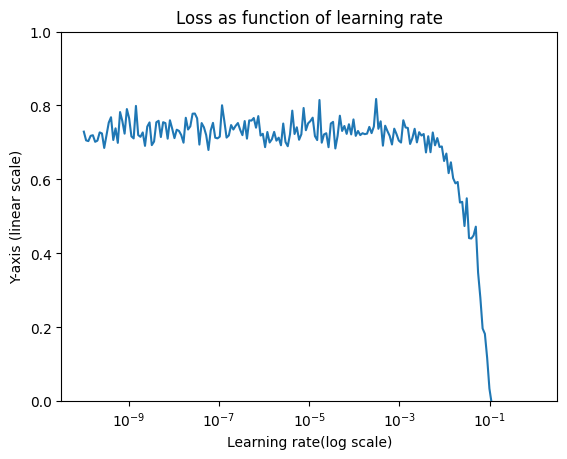

In [225]:
losses = lrrt_results

import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
x = np.array(lrrt_lrs)
y = losses

# Create the plot
fig, ax = plt.subplots()
ax.semilogx(x, y)
ax.set_xlabel('Learning rate(log scale)')
ax.set_ylabel('Y-axis (linear scale)')
ax.set_title('Loss as function of learning rate')
plt.gca().set_ylim([0, 1.0])
plt.show()

In [208]:
lr_clas=0.033
optimizer = Adam(learning_rate=lr_clas/20)

modelclass.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=optimizer,
              metrics=['accuracy'])
modelclass.fit(x_train_bin,
          y_train_nocon,
          batch_size=128,
          epochs=90,
          verbose=2,
          validation_data=(x_test_bin, y_test))

fair_nn_results = modelclass.evaluate(x_test_bin, y_test)

Epoch 1/90
81/81 - 1s - loss: 0.2167 - accuracy: 0.8870 - val_loss: 0.2173 - val_accuracy: 0.8699 - 527ms/epoch - 7ms/step
Epoch 2/90
81/81 - 0s - loss: 0.2158 - accuracy: 0.9013 - val_loss: 0.2153 - val_accuracy: 0.9167 - 171ms/epoch - 2ms/step
Epoch 3/90
81/81 - 0s - loss: 0.2157 - accuracy: 0.9031 - val_loss: 0.2144 - val_accuracy: 0.9167 - 170ms/epoch - 2ms/step
Epoch 4/90
81/81 - 0s - loss: 0.2159 - accuracy: 0.8978 - val_loss: 0.2193 - val_accuracy: 0.8313 - 178ms/epoch - 2ms/step
Epoch 5/90
81/81 - 0s - loss: 0.2160 - accuracy: 0.8921 - val_loss: 0.2151 - val_accuracy: 0.9167 - 181ms/epoch - 2ms/step
Epoch 6/90
81/81 - 0s - loss: 0.2158 - accuracy: 0.9033 - val_loss: 0.2143 - val_accuracy: 0.9167 - 171ms/epoch - 2ms/step
Epoch 7/90
81/81 - 0s - loss: 0.2154 - accuracy: 0.9014 - val_loss: 0.2177 - val_accuracy: 0.8313 - 173ms/epoch - 2ms/step
Epoch 8/90
81/81 - 0s - loss: 0.2158 - accuracy: 0.8914 - val_loss: 0.2144 - val_accuracy: 0.9167 - 171ms/epoch - 2ms/step
Epoch 9/90
81/81

Epoch 68/90
81/81 - 0s - loss: 0.2157 - accuracy: 0.8939 - val_loss: 0.2139 - val_accuracy: 0.9167 - 176ms/epoch - 2ms/step
Epoch 69/90
81/81 - 0s - loss: 0.2155 - accuracy: 0.9006 - val_loss: 0.2206 - val_accuracy: 0.8313 - 181ms/epoch - 2ms/step
Epoch 70/90
81/81 - 0s - loss: 0.2162 - accuracy: 0.8965 - val_loss: 0.2159 - val_accuracy: 0.8699 - 170ms/epoch - 2ms/step
Epoch 71/90
81/81 - 0s - loss: 0.2156 - accuracy: 0.8979 - val_loss: 0.2149 - val_accuracy: 0.9167 - 168ms/epoch - 2ms/step
Epoch 72/90
81/81 - 0s - loss: 0.2156 - accuracy: 0.9035 - val_loss: 0.2163 - val_accuracy: 0.8699 - 170ms/epoch - 2ms/step
Epoch 73/90
81/81 - 0s - loss: 0.2165 - accuracy: 0.8881 - val_loss: 0.2134 - val_accuracy: 0.9167 - 165ms/epoch - 2ms/step
Epoch 74/90
81/81 - 0s - loss: 0.2164 - accuracy: 0.8952 - val_loss: 0.2142 - val_accuracy: 0.9167 - 168ms/epoch - 2ms/step
Epoch 75/90
81/81 - 0s - loss: 0.2163 - accuracy: 0.8978 - val_loss: 0.2160 - val_accuracy: 0.8699 - 173ms/epoch - 2ms/step
Epoch 76

In [162]:
modelclass.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 16)                0         
                                                                 
 dense_66 (Dense)            (None, 2)                 34        
                                                                 
 dense_67 (Dense)            (None, 1)                 3         
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


## 4. Comparison

Higher resolution input and a more powerful model make this problem easy for the CNN. While a classical model of similar power (~32 parameters) trains to a similar accuracy in a fraction of the time. One way or the other, the classical neural network easily outperforms the quantum neural network. For classical data, it is difficult to beat a classical neural network.

In [ ]:
qnn_accuracy = qnn_results[1]
cnn_accuracy = cnn_results[1]
fair_nn_accuracy = fair_nn_results[1]

sns.barplot(x=["Quantum", "Classical, full", "Classical, fair"],
            y=[qnn_accuracy, cnn_accuracy, fair_nn_accuracy])